In [28]:
from keras.applications import VGG16
import keras_metrics as km

In [29]:
conv_base = VGG16(weights='imagenet',
                  include_top=False, #not using the pre-trained classifier 
                  input_shape=(400, 400, 3))
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
__________

In [30]:
import os
import numpy as np

In [31]:
from keras.preprocessing.image import ImageDataGenerator

In [32]:
base_dir = 'D:/Education/Makerere/Research/Implementation/final_images'

In [33]:
train_dir= os.path.join(base_dir, 'training')
validation_dir= os.path.join(base_dir, 'validation')
test_dir= os.path.join(base_dir, 'test')

In [34]:
datagen = ImageDataGenerator(rescale = 1./255)

In [35]:
batch_size = 5

In [36]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 12, 12, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(400, 400),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [37]:
train_features, train_labels = extract_features(train_dir, 88)

validation_features, validation_labels = extract_features(validation_dir, 30)

test_features, test_labels = extract_features(test_dir, 30)

Found 88 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


In [38]:
train_features = np.reshape(train_features, (88, 12 * 12 * 512))
validation_features = np.reshape(validation_features, (30, 12 * 12 * 512))
test_features = np.reshape(test_features, (30, 12 * 12 * 512))

In [39]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=12 * 12 * 512))
model.add(layers.Dropout(0.001))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc', km.binary_precision(), km.binary_recall()])

history = model.fit(train_features, train_labels,
                            epochs=13,
                            batch_size=5,
                            validation_data=(validation_features, validation_labels))

Train on 88 samples, validate on 30 samples
Epoch 1/13
88/88 [==============================] - 3s 36ms/step - loss: 0.6139 - acc: 0.6477 - precision: 0.6275 - recall: 0.7273 - val_loss: 0.3361 - val_acc: 0.8667 - val_precision: 0.9231 - val_recall: 0.8000
Epoch 2/13
88/88 [==============================] - 3s 34ms/step - loss: 0.3697 - acc: 0.8409 - precision: 0.8750 - recall: 0.7955 - val_loss: 0.3057 - val_acc: 0.9000 - val_precision: 0.8750 - val_recall: 0.9333
Epoch 3/13
88/88 [==============================] - 3s 35ms/step - loss: 0.3109 - acc: 0.8636 - precision: 0.8636 - recall: 0.8636 - val_loss: 0.3724 - val_acc: 0.8667 - val_precision: 0.7895 - val_recall: 1.0000
Epoch 4/13
88/88 [==============================] - 3s 34ms/step - loss: 0.2261 - acc: 0.9205 - precision: 0.9744 - recall: 0.8636 - val_loss: 0.2860 - val_acc: 0.8333 - val_precision: 0.7778 - val_recall: 0.9333
Epoch 5/13
88/88 [==============================] - 3s 34ms/step - loss: 0.1944 - acc: 0.9545 - precisio

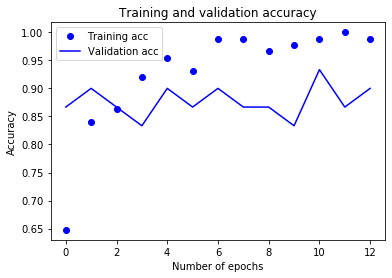

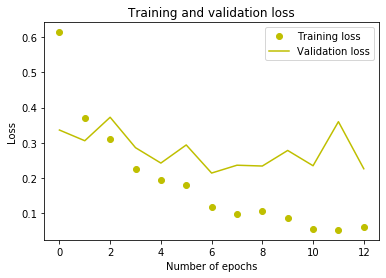

<Figure size 432x288 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'yo', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.show()

In [41]:
test_loss, test_acc, test_precision, test_recall  = model.evaluate(test_features, test_labels)
print('test accuracy is:', test_acc)
print('test precision is:', test_precision)
print('test recall is:', test_recall)

30/30 [==============================] - 0s 767us/step
test accuracy is: 0.800000011920929
test precision is: 0.7647058778546713
test recall is: 0.866666660888889


## Using data augmentation

In [42]:
from keras import models
from keras import layers

#adding a densely connected classifier on top of the convolutional base
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 12, 12, 512)       14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 73728)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               18874624  
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 33,589,569
Trainable params: 33,589,569
Non-trainable params: 0
_________________________________________________________________


In [43]:
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False
print('This is the number of trainable weights after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30
This is the number of trainable weights after freezing the conv base: 4


In [44]:
#Training the model end to end with a frozen convolutional base

from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import keras_metrics as km

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(400, 400),
                                                    batch_size=5,
                                                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size=(400, 400),
                                                        batch_size=5,
                                                        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc', km.binary_precision(), km.binary_recall()])

history = model.fit_generator(train_generator,
                              steps_per_epoch=20,
                              epochs=11,
                              validation_data=validation_generator,
                              validation_steps=50)

Found 88 images belonging to 2 classes.
Found 30 images belonging to 2 classes.
Epoch 1/11
20/20 [==============================] - 213s 11s/step - loss: 0.6173 - acc: 0.6397 - precision: 0.6522 - recall: 0.6000 - val_loss: 0.4001 - val_acc: 0.8080 - val_precision: 0.9140 - val_recall: 0.6800
Epoch 2/11
20/20 [==============================] - 231s 12s/step - loss: 0.4871 - acc: 0.7571 - precision: 0.8250 - recall: 0.6735 - val_loss: 0.4653 - val_acc: 0.7920 - val_precision: 0.7062 - val_recall: 1.0000
Epoch 3/11
20/20 [==============================] - 241s 12s/step - loss: 0.4175 - acc: 0.8135 - precision: 0.8163 - recall: 0.8163 - val_loss: 0.2827 - val_acc: 0.9000 - val_precision: 0.9310 - val_recall: 0.8640
Epoch 4/11
20/20 [==============================] - 246s 12s/step - loss: 0.2822 - acc: 0.8635 - precision: 0.9070 - recall: 0.8125 - val_loss: 0.3957 - val_acc: 0.8360 - val_precision: 0.7545 - val_recall: 1.0000
Epoch 5/11
20/20 [==============================] - 251s 13s/ste

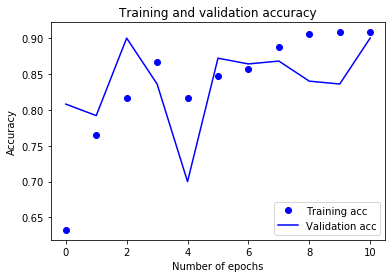

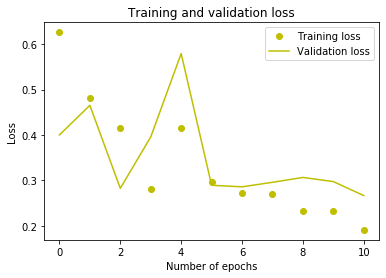

<Figure size 432x288 with 0 Axes>

In [45]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'yo', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.show()

In [46]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(400, 400),
                                                  batch_size=5,
                                                  class_mode='binary')

#test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
#print('test acc:', test_acc)

test_loss, test_acc, test_precision, test_recall  = model.evaluate_generator(test_generator, steps=50)
print('test accuracy is:', test_acc)
print('test precision is:', test_precision)
print('test recall is:', test_recall)

Found 30 images belonging to 2 classes.
test accuracy is: 0.8000000107288361
test precision is: 0.7919999993664001
test recall is: 0.8048780481261154


## Finetuning

In [47]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 400, 400, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
__________

In [48]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
#Fine-tuning the model

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc', km.binary_precision(), km.binary_recall()])

history = model.fit_generator(train_generator,
                              steps_per_epoch=20,
                              epochs=3,
                              validation_data=validation_generator,
                              validation_steps=50)

Epoch 1/3
20/20 [==============================] - 258s 13s/step - loss: 0.2650 - acc: 0.8735 - precision: 0.9091 - recall: 0.8333 - val_loss: 0.2430 - val_acc: 0.9320 - val_precision: 0.9297 - val_recall: 0.9370
Epoch 2/3
20/20 [==============================] - 269s 13s/step - loss: 0.1921 - acc: 0.9235 - precision: 0.9348 - recall: 0.9149 - val_loss: 0.4037 - val_acc: 0.8720 - val_precision: 1.0000 - val_recall: 0.7377
Epoch 3/3
20/20 [==============================] - 255s 13s/step - loss: 0.1305 - acc: 0.9500 - precision: 0.9400 - recall: 0.9592 - val_loss: 0.2911 - val_acc: 0.8920 - val_precision: 0.8657 - val_recall: 0.9280


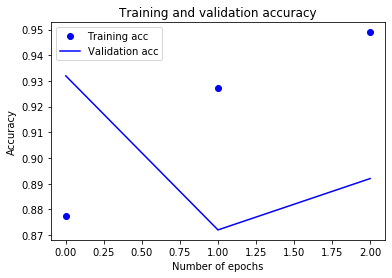

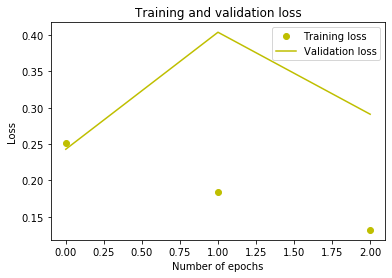

<Figure size 432x288 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'yo', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.show()

In [50]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(400, 400),
                                                  batch_size=5,
                                                  class_mode='binary')

#test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
#print('test acc:', test_acc)

test_loss, test_acc, test_precision, test_recall  = model.evaluate_generator(test_generator, steps=50)
print('test accuracy is:', test_acc)
print('test precision is:', test_precision)
print('test recall is:', test_recall)

Found 30 images belonging to 2 classes.
test accuracy is: 0.828000009059906
test precision is: 0.8059701486522611
test recall is: 0.8639999993088
